https://data.mendeley.com/datasets/3t9vbwxgr5/2/files/d2c58546-d8be-4d57-af14-b61337c927b2

In [20]:
from IPython import display
from IPython.display import Markdown as md


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Read data

In [21]:
df = pd.read_csv("tcc_ceds_music.csv", index_col=0)
df["genre"].value_counts()

pop        7042
country    5445
blues      4604
rock       4034
jazz       3845
reggae     2498
hip hop     904
Name: genre, dtype: int64

In [22]:
pop_df = df[df["genre"] == "pop"]["lyrics"].reset_index(drop=True)
pop_df.head()


0    hold time feel break feel untrue convince spea...
1    believe drop rain fall grow believe darkest ni...
2    sweetheart send letter goodbye secret feel bet...
3    kiss lips want stroll charm mambo chacha merin...
4    till darling till matter know till dream live ...
Name: lyrics, dtype: object

# Creating Dictionary

In [23]:
# from functools import reduce
# vocab_set = set(reduce(lambda x, y: x+y, pop_df.str.split(" ")))
# vocab = sorted(list(vocab_set))
# print(len(vocab), pop_df.shape[0])
# # vocab

In [24]:
vectorizer = CountVectorizer(decode_error='ignore')
total_features_words = vectorizer.fit_transform(pop_df)
total_features_words.shape
# 7042 -> Training instances
# 21954 -> Total words


(7042, 21954)

Need to trim the vocab size. Filter by IDF value?

In [25]:
vectorizer = TfidfVectorizer(decode_error='ignore'
                            # ,ngram_range = (1,2)
                            ,use_idf = True
                            ,strip_accents = 'ascii'
                            # ,smooth_idf = False
                            )
song_vectors = vectorizer.fit_transform(pop_df)
print(song_vectors.shape)
# 7042 -> Training instances
# 21954 -> Total words
print(min(vectorizer.idf_), max(vectorizer.idf_))
idf_vocab = pd.Series(vectorizer.idf_, index= vectorizer.get_feature_names())
idf_vocab


(7042, 21735)
1.6680494734679525 9.166642314185465


/Users/rchaks/opt/anaconda3/envs/aml-proj/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


aaaa               9.166642
aaaaaaaaaaa        9.166642
aaaaaaasasarock    9.166642
aaaaaalcohol       9.166642
aaaaah             9.166642
                     ...   
zooz               9.166642
zulu               9.166642
zumba              9.166642
zuri               9.166642
zzzz               9.166642
Length: 21735, dtype: float64

Text(0.5, 1.0, 'Word Distribution')

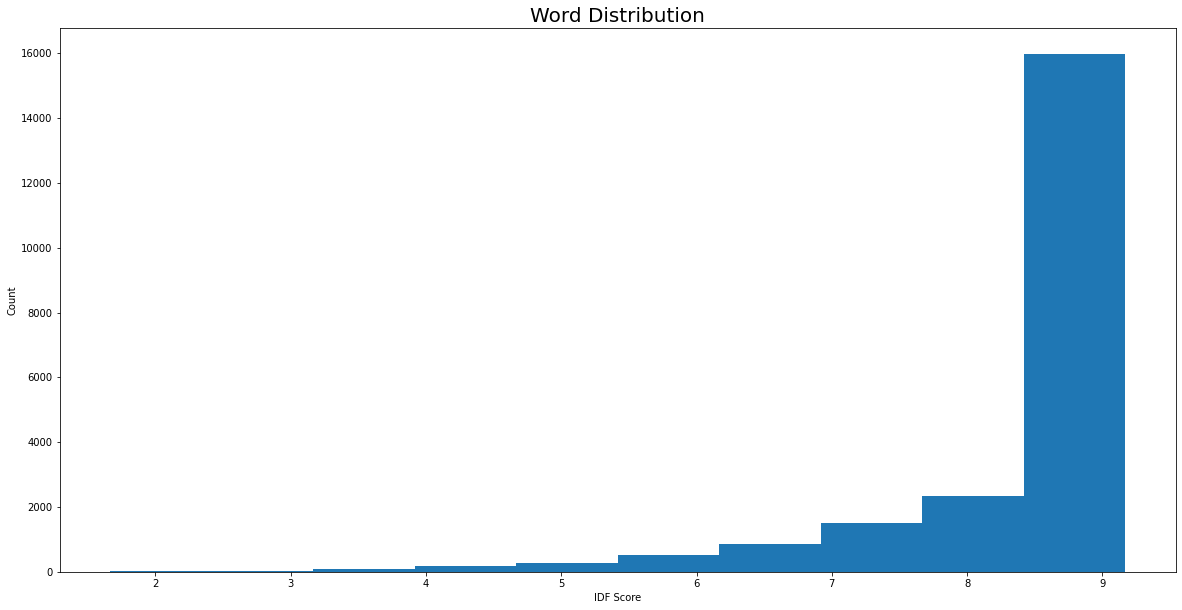

In [26]:
plt.figure(figsize = (20,10))
plt.hist(vectorizer._tfidf.idf_)
plt.xlabel("IDF Score")
plt.ylabel("Count")
plt.title("Word Distribution", fontsize = 20)
        

In [27]:
# Selecting top 10% most frequently occouring words
idf_vocab = idf_vocab[idf_vocab <= idf_vocab.quantile(q = 0.10)]
print(len(idf_vocab))
idf_vocab.head()

2206


abandon    6.815267
able       6.170910
abuse      6.527585
accept     6.458592
account    7.087201
dtype: float64

In [28]:

vectorizer = CountVectorizer(decode_error='ignore'
                            # ,ngram_range = (1,2)
                            ,strip_accents = 'ascii'
                            # ,smooth_idf = False
                            ,vocabulary = set(idf_vocab.index)
                        )
X = vectorizer.fit_transform(pop_df)
print(song_vectors.shape)
# 7042 -> Training instances
# 21954 -> Total words
vocab= vectorizer.get_feature_names_out()
print(vocab)
print(X.toarray()[1])

(7042, 21735)
['abandon' 'able' 'abuse' ... 'youth' 'zero' 'zone']
[0 0 0 ... 0 0 0]


# GAN

In [29]:
from utils import Logger

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torch.utils.data import DataLoader


In [30]:
X = torch.tensor(X.toarray())
print(X.shape, X.shape[0])
vocab_size = X.shape[1]

batch_size = 32
num_batches = X.shape[0]//batch_size

dataloader = DataLoader(X, batch_size= batch_size)
dataloader

torch.Size([7042, 2206]) 7042


# Discriminator Net

In [31]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = vocab_size
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = x.type(torch.FloatTensor)
        # print("Discriminator",x.shape)
        x = self.hidden0(x)
        # print(x.shape)
        x = self.hidden1(x)
        # print(x.shape)
        x = self.hidden2(x)
        # print(x.shape)
        x = self.out(x)
        # print(x.shape)
        return x
    
def vec_to_text(array):
    return list(map(lambda vec: " ".join(list(vocab[vec > 0.5])), array))

def text_to_vec(array):
    return vectorizer.fit_transform(array)
    # return images.view(images.size(0), 784)

# def vectors_to_images(vectors):
#     return vectors.view(vectors.size(0), 1, 28, 28)

# Generator Netowrk

In [32]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 1000
        n_out = vocab_size
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.type(torch.FloatTensor)
        # print("Generator", x.shape)
        x = self.hidden0(x)
        # print(x.shape)
        x = self.hidden1(x)
        # print(x.shape)
        x = self.hidden2(x)
        # print(x.shape)
        x = self.out(x)
        # print(x.shape)
        return x
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, 1000))
    # n = Variable(torch.randn(size, 256))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [33]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

# Optimization

In [34]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 200

# Training

## bleh

In [35]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))#.type(torch.LongTensor)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))#.type(torch.LongTensor)
    if torch.cuda.is_available(): return data.cuda()
    return data

In [36]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    # print("Training Discriminator on real data")
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    # print("real_data:", real_data.size(), 
    #     "\nprediction_real:", prediction_real.size(),
    #     "\nreal_data_target:", real_data_target(real_data.size(0)).size())
        
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

## Generate Samples for Testing

In [37]:
num_test_samples = 16
test_noise = noise(num_test_samples)
test_noise.shape

torch.Size([16, 1000])

## Start Training

In [38]:
logging = Logger(model_name='VGAN', data_name='tcc_ceds_music_dataset')

for epoch in range(num_epochs):
    # for n_batch, real_batch in tqdm(enumerate(dataloader)):
    for n_batch, real_batch in enumerate(dataloader):
        # print(n_batch, real_batch.size())

        # 1. Train Discriminator
        real_data = Variable(real_batch)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        
        # Generate fake data and train G
        
        # print(real_data.size(), real_data.size(0), noise(real_data.size(0)).size())
        fake_data = generator(noise(real_data.size(0))).detach()
        # print("Fake Data:",fake_data.shape)
        
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logging.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress
        if (n_batch) % 50 == 0:
            display.clear_output(True)
            # Display Images
            test_output = generator(test_noise).data.cpu().type(torch.FloatTensor)
            test_text = vec_to_text(test_output)
            # logging.log_images(test_text, num_test_samples, epoch, n_batch, num_batches)
            # Display status Logs
            logging.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        #Model Checkpoints
        logging.save_models(generator, discriminator, epoch)

Epoch: [199/200], Batch Num: [200/220]
Discriminator Loss: 0.2362, Generator Loss: 3.5426
D(x): 0.9549, D(G(z)): 0.1499


# Check Output

In [40]:
vec_to_text(generator(test_noise).data.cpu().type(torch.FloatTensor))

['away baby believe better cause close come dear dream eye fall good hand head hear leave life line live look mind need open people play sing sleep song start stay tell think touch true want wish write',
 'blue days gonna hear kiss know life live need stay tell think want',
 'baby better blue break breathe bring cause change come dream easy fall fight get girl give gonna hear know leave like live lose need pain pretty real save sleep song soon sorrow start stay summer talk tell today tomorrow turn want watch word world',
 'ahead arm away better blood blow blue break bring burn change club come dance days dream fear follow forget fuck future get girl go gonna hang kiss know leave lie life like little lonely long lose love make meet mind money mother need night ohoh pity point return sail say scream secret shoot sleep somebody soon start stay street string time tonight tree try turn walk want watch whisper wind woman world',
 'arm away beauty better blood break breathe bring burn cause c

***
# END
***